Fraud machine learning model based on local (Ugandan) financial Behaviours.

What makes it different from existing hard coded rules;

1. Saves us precomputation everytime a transaction happens
High numbers of false positives
2. Adaptive to the rapidly changing data
3. Detects unknown fraud

In [1]:
# import libraries
import pandas as pd
import numpy as np
import random
import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_predict, StratifiedKFold, ShuffleSplit, KFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from statistics import mean
from itertools import groupby
import zlib
import joblib
import os
import re
import json
from imblearn.over_sampling import SMOTE
import shap
import duckdb
import pyarrow.dataset as ds
import pyarrow.parquet as pq
import pyarrow as pa
import pandas as pd
import time
from statistics import mean
import pickle
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import load_model
from tensorflow.keras import mixed_precision
import tensorflow as tf
import joblib
from dateutil import parser as datetime_parser
import matplotlib.pyplot as plt

os.cpu_count()

8

In [2]:
%%script echo skipping mounting google drive
from google.colab import drive
drive.mount('/content/drive')

skipping mounting google drive


In [3]:
TXN_FRAUD_CATEGORIES_SETTINGS = {
  "same_amount_deposit":{"threshold":5, "fetch_size": 5,"ruleCode": "SAD"},
  "split_transaction":{"threshold":2, "fetch_size": 2,"ruleCode": "ST"},
  "self_cashin":{"threshold":1, "fetch_size": 2,"ruleCode": "SC"},
  "deposit_without_float":{"threshold":1, "fetch_size": 2,"ruleCode": "DWF"},
  "successive_failed_multiple_cashouts":{"threshold":3, "fetch_size": 4,"ruleCode": "SFMC"},
  "successive_cashin_after_cashout":{"threshold":2, "fetch_size": 2,"ruleCode": "SCAC"},
  "multiple_cashins":{"threshold":20, "fetch_size": 20,"ruleCode": "MC"},
  "funny_amounts":{"threshold":5, "fetch_size": 50,"ruleCode": "FA"},
  "float_balance_limit":{"threshold":1, "fetch_size": 1,"ruleCode": "FBL"},
  "ctabn":{"threshold":1, "fetch_size": 1,"ruleCode": "CTABN"},
  "normal":{"threshold":random.randint(1,5), "fetch_size": 5,"ruleCode": "N"},
}

In [4]:
TXN_FRAUD_CATEGORIES_KEYS = list(TXN_FRAUD_CATEGORIES_SETTINGS.keys())

TXN_FRAUD_CATEGORY_CODES = [TXN_FRAUD_CATEGORIES_SETTINGS[fraud_check]["ruleCode"] for fraud_check in TXN_FRAUD_CATEGORIES_KEYS]
TXN_FRAUD_CATEGORY_FETCH_SIZES = [TXN_FRAUD_CATEGORIES_SETTINGS[fraud_check]["fetch_size"] for fraud_check in TXN_FRAUD_CATEGORIES_KEYS]

print(TXN_FRAUD_CATEGORY_CODES)
print(TXN_FRAUD_CATEGORY_FETCH_SIZES)

['SAD', 'ST', 'SC', 'DWF', 'SFMC', 'SCAC', 'MC', 'FA', 'FBL', 'CTABN', 'N']
[5, 2, 2, 2, 4, 2, 20, 50, 1, 1, 5]


In [39]:
drive_models_path = './drive/MyDrive/MCSC/models'
datasets_path = './drive/MyDrive/MCSC/datasets'

normal_txns_from_june_to_october_parquet_file_path = datasets_path + '/normal_txns_from_june_to_october.parquet'
normal_txns_from_june_to_october_json_file_path = datasets_path + '/normal-txns-from-june-to-october.json'
normal_txn_behaviours_file_path = datasets_path + "/normal_txn_behaviours.parquet"

fraud_txns_json_file_path = datasets_path + "/fraud_txns.json"
fraud_txns_behaviours_file_path = datasets_path + "/fraud_txns_behaviours.parquet"

autoencoder_path = drive_models_path + '/autoencoder'
autoencoder_behaviour_scaler_path = autoencoder_path + "/behaviour_scaler.pkl"
autoencoder_modelh5_path = autoencoder_path + "/autoencoder_model.h5"
autoencoder_encoder_model_path = autoencoder_path + "/encoder_model.h5"
autoencoder_threshold_path = autoencoder_path + "/autoencoder_threshold.pkl"

rf_path = drive_models_path + '/rf'
rf_model_path = rf_path + "/rf_model.pkl"
rf_txn_type_encoder_path = rf_path + "/txn_type_encoder.pkl"
rf_label_encoder_path = rf_path + "/label_encoder.pkl"

# round(os.path.getsize(normal_txns_from_june_to_october_parquet_file_path) / (1024 * 1024), 2)

In [6]:
%%script echo skipping converting normal txns json to parquet for better compression
duckdb.sql(f"COPY (SELECT * FROM read_json_auto('{normal_txns_from_june_to_october_json_file_path}')) TO '{normal_txns_from_june_to_october_parquet_file_path}' (FORMAT PARQUET);")

skipping converting normal txns json to parquet for better compression


In [7]:
%%script echo skipping batching up txns in the parquet file
import pyarrow as pa
import pyarrow.dataset as ds
import pyarrow.parquet as pq

def clean_txn_object(txn):
    """Convert Mongo extended JSON to clean Python dict."""
    clean = dict(txn)

    # Convert decimals
    for key in ["amount", "agentFloatBalanceBefore", "agentFloatBalanceAfter"]:
        val = clean.get(key)
        if isinstance(val, dict) and "$numberDecimal" in val:
            clean[key] = float(val["$numberDecimal"])

    # Convert date
    dt = clean.get("createdAt")
    if isinstance(dt, dict) and "$date" in dt:
        clean["createdAt"] = dt["$date"]

    return clean


INPUT = normal_txns_from_june_to_october_parquet_file_path
OUTPUT = "test_batched_txns.parquet"

open(OUTPUT, "wb").close()

dataset = ds.dataset(INPUT, format="parquet")
batches = dataset.to_batches()
first_batch = next(batches)

print("Rows in first batch:", first_batch.num_rows)

txns_column = first_batch.column(1)

writer = None
output_count = 0

for row_idx in range(first_batch.num_rows):

    BATCH_SIZE = random.choices(TXN_FRAUD_CATEGORY_FETCH_SIZES)

    print(f"\n=== Processing row {row_idx} ===")

    list_scalar = txns_column[row_idx]
    txns = list_scalar.as_py()

    print("Number of transactions:", len(txns))

    if len(txns) == 0:
        continue

    # Convert values
    cleaned = [clean_txn_object(t) for t in txns]

    # Reverse small batch (safe, <= 50)
    reversed_txns = list((cleaned))

    # Chunk into mini-batches
    for start in range(0, len(reversed_txns), BATCH_SIZE):
        chunk = reversed_txns[start:start + BATCH_SIZE]

        # Build arrow table
        out_table = pa.Table.from_pylist([{"batch": chunk}])

        # Create writer once
        if writer is None:
            writer = pq.ParquetWriter(OUTPUT, out_table.schema)
            print("Created test parquet writer.")

        writer.write_table(out_table)
        output_count += 1

if writer:
    writer.close()

print("\nDone!")
print("Batches written:", output_count)
print("Output file:", OUTPUT)


skipping batching up txns in the parquet file


In [8]:
# set seeding constants for reproduceability
random.seed(42)
np.random.seed(42)

print(random.randint(0, 10))
print(np.random.rand())

10
0.3745401188473625


In [9]:
# random phone generator
class PhoneGenerator:
    def __init__(self, repeat_probability=0.2, max_unique=100):
        self.repeat_probability = repeat_probability
        self.max_unique = max_unique
        self.generated = []

    def _random_phone(self):
        return "2567" + "".join(str(random.randint(0, 9)) for _ in range(8))

    def get_phone(self):
        if self.generated and (random.random() < self.repeat_probability or len(self.generated) >= self.max_unique):
            return random.choice(self.generated)
        new_phone = self._random_phone()
        self.generated.append(new_phone)
        return new_phone


phone_generator = PhoneGenerator(repeat_probability=0.4)
generated_phone_numbers = []

def random_phone():
  return phone_generator.get_phone()

for _ in range(10):
  generated_phone_numbers.append(random_phone())

print(len(list(set(generated_phone_numbers))))

6


In [10]:
# set constants
TX_TYPES = [
    "cashin", "cashout", "withdraw", "airtime", "payin", "payout", "tv",
    "water", "umeme", "data", "voice", "ura", "collection", "payin", "payout",
    "Float received", "Float sent", "advance", "registration", "topup", "bank_deposits", "reversal", "system"
]
AGENT_PHONE_NUMBER = random_phone()
SUCCEEDED = "SUCCEEDED"
FAILED = "FAILED"
TX_STATES = [SUCCEEDED, FAILED]

In [11]:
def matches_any(patterns, text):
    return any(re.search(p, text, re.IGNORECASE) for p in patterns)

def get_transaction_type_category(transaction_type_string):
    if matches_any([r'cashin', r'deposit'], transaction_type_string):
        return 'cashin'
    elif matches_any([r'cashout', r'withdraw'], transaction_type_string):
        return 'cashout'
    elif matches_any([r'payin'], transaction_type_string):
        return 'payin'
    elif matches_any([r'airtime'], transaction_type_string):
        return 'airtime'
    elif matches_any([r'voice'], transaction_type_string):
        return 'voice'
    elif matches_any([r'data'], transaction_type_string):
        return 'data'
    elif matches_any([r'registration'], transaction_type_string):
        return 'registration'
    elif matches_any([r'added float', r'topup'], transaction_type_string):
        return 'topup'
    elif matches_any([r'stanbic'], transaction_type_string):
        return 'bank_deposits'
    elif matches_any([r'umeme'], transaction_type_string):
        return 'umeme'
    elif matches_any([r'advance'], transaction_type_string):
        return 'advance'
    elif matches_any([r'payout', r'pay out'], transaction_type_string):
        return 'payout'
    elif matches_any([r'reversal'], transaction_type_string):
        return 'reversal'
    elif matches_any([r'stu', r'tv'], transaction_type_string):
        return 'tv'
    elif matches_any([r'', r' '], transaction_type_string):
        return 'system'
    elif transaction_type_string in TX_TYPES:
        return transaction_type_string
    else:
        raise ValueError(f"Invalid transaction type {transaction_type_string}")

In [12]:
next_start_time = "2025-09-01T12:40:27.000Z"
next_start_time

'2025-09-01T12:40:27.000Z'

In [13]:
# random time
def random_time(start, minutes_step=30):
    base = datetime.datetime.strptime(start, "%Y-%m-%dT%H:%M:%S.%fZ")
    time = (base + datetime.timedelta(minutes=(random.uniform(0, 1)) * minutes_step)).strftime("%Y-%m-%dT%H:%M:%S.%fZ")

    global next_start_time
    next_start_time = time

    return str( time)

print(random_time(next_start_time, 30))

2025-09-01T12:48:27.560080Z


In [14]:
def generate_non_500_multiple(start, end):
    while True:
        if random.random() < 0.2:
            n = random.randint(start // 100, end // 100) * 100
        else:
            n = random.randint(start, end)

        if n % 500 != 0 and start <= n <= end:
            return n


print(generate_non_500_multiple(1000, 100000))

85939


In [15]:
def generate_500_multiple(start, end):
    min_mult = (start + 499) // 500
    max_mult = end // 500

    n = random.randint(min_mult, max_mult) * 500
    return n


print(generate_500_multiple(1000, 100000))

10000


In [16]:
def simulate_txns(txnType = 'normal', minutes_step=30):
    initial_balance = random.randint(5000000, 8000000)
    base_customer_phone = random_phone()
    base_transaction_amount = generate_500_multiple(1000, 10000)
    fetch_size = TXN_FRAUD_CATEGORIES_SETTINGS[txnType]["fetch_size"]
    threshold = TXN_FRAUD_CATEGORIES_SETTINGS[txnType]["threshold"]
    special_indices = set(random.sample(range(fetch_size), threshold))
    past_fraud_count = random.choices(
                population=[0, 1, 2, 3],
                weights=[0.40, 0.20, 0.20, 0.20],
                k=1
            )[0]
    special_indices_subset = random.sample(list(special_indices), int(threshold/2) if past_fraud_count > 0 else int(threshold))

    txns = []
    for i in range(fetch_size):
        transaction_amount = generate_500_multiple(1000, 10000)
        float_balance_after = initial_balance - transaction_amount

        txn = {
            "createdAt": random_time(next_start_time, minutes_step),
            "amount": transaction_amount,
            "agentFloatBalanceBefore": initial_balance,
            "agentFloatBalanceAfter": float_balance_after,
            "agentPhoneNumber": AGENT_PHONE_NUMBER,
            "customerPhoneNumber": random_phone(),
            "state": random.choices(
                population=[SUCCEEDED, FAILED],
                weights=[0.90, 0.10],
                k=1
            )[0],
            "penaltyCount": 0,
            "label": TXN_FRAUD_CATEGORIES_SETTINGS[txnType]["ruleCode"]
        }

        if txnType == 'same_amount_deposit':
          txn.update({
            "transactionType": "cashin",
            "amount": base_transaction_amount,
            "state": SUCCEEDED
          })

        elif txnType == 'split_transaction':
          if i == 0:
            txn.update({
              "transactionType": "cashin",
              "customerPhoneNumber": base_customer_phone,
              "state": SUCCEEDED,
            })
          else:
            txn.update({
              "transactionType": "cashin",
              "customerPhoneNumber": base_customer_phone,
              "state": None,
              "agentFloatBalanceAfter": None,
            })

        elif txnType == 'successive_cashin_after_cashout':
          if i == 0:
            txn.update({
              "transactionType": "cashout",
              "state": SUCCEEDED,
              "amount": base_transaction_amount,
              "penaltyCount": past_fraud_count
            })
          else:
            txn.update({
              "transactionType": "cashin",
              "amount": base_transaction_amount,
              "agentFloatBalanceAfter": None,
              "state": None,
              "penaltyCount": past_fraud_count
            })

        elif txnType == 'self_cashin':
          txn.update({
            "transactionType": "cashin",
            "customerPhoneNumber": AGENT_PHONE_NUMBER,
            "agentFloatBalanceAfter": None,
            "state": None,
          })

        elif txnType == 'funny_amounts':
          txn.update({
            "transactionType": random.choice(TX_TYPES),
            "penaltyCount": past_fraud_count
          })

          if i in special_indices_subset:
            txn.update({
              "transactionType": "cashin",
              "amount": generate_non_500_multiple(1000, 100000),
              "state": SUCCEEDED,
            })

        elif txnType == 'deposit_without_float':
          txn.update({
            "transactionType": "cashin",
            "agentFloatBalanceBefore": random.randint(-2000000, 0),
            "agentFloatBalanceAfter": None,
            "state": None,
          })

        elif txnType == 'successive_failed_multiple_cashouts':
          txn.update({
            "transactionType": "cashout",
            "agentFloatBalanceBefore": random.randint(50000, 2000000),
            "customerPhoneNumber": base_customer_phone,
            "state": FAILED,
            "penaltyCount": past_fraud_count
          })

        elif txnType == 'multiple_cashins':
          txn.update({
            "transactionType": "cashin",
            "agentFloatBalanceBefore": random.randint(1000, 20000),
            "state": SUCCEEDED,
            "penaltyCount": past_fraud_count
          })

        # incoming transactions will not have balance after and state, they are being checked
        if i == fetch_size - 1:
          txn.update({
              "agentFloatBalanceAfter": None,
              "state": None,
            })

        txns.append(txn)

        initial_balance = float_balance_after
    return txns

In [17]:
def simulate_successive_cashin_after_cashout():
    return simulate_txns("successive_cashin_after_cashout", 5)

df = pd.DataFrame(simulate_successive_cashin_after_cashout())
df = df.head()
df

,createdAt,amount,agentFloatBalanceBefore,agentFloatBalanceAfter,agentPhoneNumber,customerPhoneNumber,state,penaltyCount,label,transactionType
0,2025-09-01T12:49:47.882343Z,6000,7554880,7547880.0,256731647525,256795931034,SUCCEEDED,3,SCAC,cashout
1,2025-09-01T12:50:51.670306Z,6000,7547880,NaN,256731647525,256772423884,None,3,SCAC,cashin


In [18]:
def simulate_funny_amounts():
    return simulate_txns("funny_amounts", 300)

df = pd.DataFrame(simulate_funny_amounts())
df = df.head()
display(df)

,createdAt,amount,agentFloatBalanceBefore,agentFloatBalanceAfter,agentPhoneNumber,customerPhoneNumber,state,penaltyCount,label,transactionType
0,2025-09-01T15:29:35.728518Z,8000,6796981,6788981.0,256731647525,256701845146,SUCCEEDED,1,FA,cashin
1,2025-09-01T20:21:09.714298Z,5000,6788981,6783981.0,256731647525,256781489325,SUCCEEDED,1,FA,advance
2,2025-09-02T00:56:42.597197Z,9000,6783981,6774981.0,256731647525,256770154303,SUCCEEDED,1,FA,withdraw
3,2025-09-02T04:36:16.933904Z,2000,6774981,6772981.0,256731647525,256782278248,SUCCEEDED,1,FA,payin
4,2025-09-02T09:14:57.376778Z,4000,6772981,6768981.0,256731647525,256734657871,SUCCEEDED,1,FA,withdraw


In [19]:
def simulate_normal():
    return simulate_txns("normal")

df = pd.DataFrame(simulate_normal())
df = df.head()
df

,createdAt,amount,agentFloatBalanceBefore,agentFloatBalanceAfter,agentPhoneNumber,customerPhoneNumber,state,penaltyCount,label
0,2025-09-06T07:20:44.329633Z,4500,7665837,7661337.0,256731647525,256716934060,SUCCEEDED,0,N
1,2025-09-06T07:37:50.058993Z,8000,7661337,7653337.0,256731647525,256750752735,SUCCEEDED,0,N
2,2025-09-06T07:46:13.444271Z,6000,7653337,7647337.0,256731647525,256748083136,SUCCEEDED,0,N
3,2025-09-06T08:06:56.541082Z,4500,7647337,7642837.0,256731647525,256777014363,SUCCEEDED,0,N
4,2025-09-06T08:18:00.777893Z,10000,7642837,NaN,256731647525,256756855744,None,0,N


In [20]:
def simulate_same_amount_deposit():
    return simulate_txns("same_amount_deposit")

df = pd.DataFrame(simulate_same_amount_deposit())
df = df.head()
df

,createdAt,amount,agentFloatBalanceBefore,agentFloatBalanceAfter,agentPhoneNumber,customerPhoneNumber,state,penaltyCount,label,transactionType
0,2025-09-06T08:47:14.508769Z,10000,5506067,5504567.0,256731647525,256727109477,SUCCEEDED,0,SAD,cashin
1,2025-09-06T09:16:12.404527Z,10000,5504567,5501067.0,256731647525,256738721489,SUCCEEDED,0,SAD,cashin
2,2025-09-06T09:28:13.677923Z,10000,5501067,5499067.0,256731647525,256763193149,SUCCEEDED,0,SAD,cashin
3,2025-09-06T09:32:42.233575Z,10000,5499067,5496067.0,256731647525,256741318699,SUCCEEDED,0,SAD,cashin
4,2025-09-06T09:55:58.481946Z,10000,5496067,NaN,256731647525,256716934060,None,0,SAD,cashin


In [21]:
def simulate_split_transaction():
    return simulate_txns("split_transaction")

df = pd.DataFrame(simulate_split_transaction())
df = df.head()
df

,createdAt,amount,agentFloatBalanceBefore,agentFloatBalanceAfter,agentPhoneNumber,customerPhoneNumber,state,penaltyCount,label,transactionType
0,2025-09-06T10:08:13.813577Z,1000,7468453,7467453.0,256731647525,256749909133,SUCCEEDED,0,ST,cashin
1,2025-09-06T10:31:51.904025Z,5000,7467453,NaN,256731647525,256749909133,None,0,ST,cashin


In [22]:
def simulate_self_cashin():
    return simulate_txns("self_cashin")

df = pd.DataFrame(simulate_self_cashin())
df = df.head()
df

,createdAt,amount,agentFloatBalanceBefore,agentFloatBalanceAfter,agentPhoneNumber,customerPhoneNumber,state,penaltyCount,label,transactionType
0,2025-09-06T10:58:32.865226Z,1500,5695930,None,256731647525,256731647525,None,0,SC,cashin
1,2025-09-06T11:15:50.109798Z,5000,5694430,None,256731647525,256731647525,None,0,SC,cashin


In [23]:
def simulate_deposit_without_float():
    return simulate_txns("deposit_without_float")


df = pd.DataFrame(simulate_deposit_without_float())
df = df.head()
df

,createdAt,amount,agentFloatBalanceBefore,agentFloatBalanceAfter,agentPhoneNumber,customerPhoneNumber,state,penaltyCount,label,transactionType
0,2025-09-06T11:16:56.164633Z,9500,-379850,None,256731647525,256766701065,None,0,DWF,cashin
1,2025-09-06T11:42:53.003684Z,7000,-954585,None,256731647525,256708760385,None,0,DWF,cashin


In [24]:
def simulate_successive_failed_multiple_cashouts():
    return simulate_txns("successive_failed_multiple_cashouts", 1)


df = pd.DataFrame(simulate_successive_failed_multiple_cashouts())
df = df.head()
df

,createdAt,amount,agentFloatBalanceBefore,agentFloatBalanceAfter,agentPhoneNumber,customerPhoneNumber,state,penaltyCount,label,transactionType
0,2025-09-06T11:42:53.824152Z,9500,921346,7613654.0,256731647525,256703482477,FAILED,2,SFMC,cashout
1,2025-09-06T11:43:52.638830Z,8500,449738,7605154.0,256731647525,256703482477,FAILED,2,SFMC,cashout
2,2025-09-06T11:44:37.416383Z,9000,1706763,7596154.0,256731647525,256703482477,FAILED,2,SFMC,cashout
3,2025-09-06T11:44:57.808898Z,7500,1065737,NaN,256731647525,256703482477,None,2,SFMC,cashout


In [25]:
def simulate_multiple_cashins():
    return simulate_txns("multiple_cashins")


df = pd.DataFrame(simulate_multiple_cashins())
df.head(20)

,createdAt,amount,agentFloatBalanceBefore,agentFloatBalanceAfter,agentPhoneNumber,customerPhoneNumber,state,penaltyCount,label,transactionType
0,2025-09-06T11:59:02.891980Z,2000,16989,6445554.0,256731647525,256759615865,SUCCEEDED,3,MC,cashin
1,2025-09-06T12:00:07.510360Z,9500,10416,6436054.0,256731647525,256763193149,SUCCEEDED,3,MC,cashin
2,2025-09-06T12:22:31.689820Z,4500,10613,6431554.0,256731647525,256711724005,SUCCEEDED,3,MC,cashin
3,2025-09-06T12:33:46.403782Z,6500,6900,6425054.0,256731647525,256779868727,SUCCEEDED,3,MC,cashin
4,2025-09-06T12:39:01.528621Z,3500,16059,6421554.0,256731647525,256769379237,SUCCEEDED,3,MC,cashin
5,2025-09-06T12:59:01.841912Z,5000,14903,6416554.0,256731647525,256774821759,SUCCEEDED,3,MC,cashin
6,2025-09-06T13:12:44.146375Z,5000,4494,6411554.0,256731647525,256741318699,SUCCEEDED,3,MC,cashin
7,2025-09-06T13:24:10.602111Z,4500,10674,6407054.0,256731647525,256764170805,SUCCEEDED,3,MC,cashin
8,2025-09-06T13:53:30.902183Z,1000,12544,6406054.0,256731647525,256740909743,SUCCEEDED,3,MC,cashin
9,2025-09-06T14:12:36.814363Z,4500,3953,6401554.0,256731647525,256721047095,SUCCEEDED,3,MC,cashin


In [26]:
def generate_dataset(num_sequences=15000):
# def generate_dataset(num_sequences=2):
    patterns = [
        simulate_same_amount_deposit,
        simulate_split_transaction,
        simulate_self_cashin,
        simulate_deposit_without_float,
        # simulate_successive_failed_multiple_cashouts,
        simulate_multiple_cashins,
        # simulate_funny_amounts,
        simulate_successive_cashin_after_cashout,
    ]

    data = []

    for _ in range(num_sequences):
        fn = random.choice(patterns)
        data.append(fn())

    return data

generated_dataset = generate_dataset()
pd.DataFrame([item for sublist in generated_dataset for item in sublist]).head(100)

,createdAt,amount,agentFloatBalanceBefore,agentFloatBalanceAfter,agentPhoneNumber,customerPhoneNumber,state,penaltyCount,label,transactionType
0,2025-09-06T17:25:10.874044Z,1500,7875951,7872951.0,256731647525,256760733754,SUCCEEDED,0,SAD,cashin
1,2025-09-06T17:35:02.281240Z,1500,7872951,7868451.0,256731647525,256710433218,SUCCEEDED,0,SAD,cashin
2,2025-09-06T18:04:39.830388Z,1500,7868451,7865451.0,256731647525,256721020539,SUCCEEDED,0,SAD,cashin
3,2025-09-06T18:12:37.491903Z,1500,7865451,7861951.0,256731647525,256799471746,SUCCEEDED,0,SAD,cashin
4,2025-09-06T18:26:54.734641Z,1500,7861951,NaN,256731647525,256789178390,None,0,SAD,cashin
...,...,...,...,...,...,...,...,...,...,...
95,2025-09-07T17:25:51.289767Z,2500,7101,6296352.0,256731647525,256779979955,SUCCEEDED,0,MC,cashin
96,2025-09-07T17:47:57.201979Z,1000,7329,NaN,256731647525,256715921249,None,0,MC,cashin
97,2025-09-07T18:17:24.235325Z,3500,7562528,7559028.0,256731647525,256774034471,SUCCEEDED,0,ST,cashin
98,2025-09-07T18:24:28.173580Z,7000,7559028,NaN,256731647525,256774034471,None,0,ST,cashin


For each transaction (except the very first for that customer), compute features based on ALL prior transactions for that customer up to that point:

1. avg_amount: average amount in history
2. unique_customers: number of distinct customers in history
3. avg_time_gap: mean minutes between prior transactions
4. transaction_count_window: number of prior transactions (history length)
5. past_fraud_count: how many prior transactions were non-normal (used for RL reward shaping)

In [27]:
def are_amounts_similar(amounts, threshold=0.1):
    cv = np.std(amounts, ddof=1) / np.mean(amounts)
    return cv, cv <= threshold

amounts = [3100100, 3000000]
cv, similar = are_amounts_similar(amounts)
print(f"CV = {cv:.3f}, Similar = {similar}")

CV = 0.023, Similar = True


In [28]:
def convert_iso_to_datetime(iso_string):
    return datetime_parser.parse(iso_string)

def get_txn_behaviours(sub_pattern):

    current_pattern_details = sub_pattern[0]

    pattern_states = [h["state"] for h in sub_pattern]

    amounts = [h["amount"] for h in sub_pattern]

    unique_customers = len(set(h["customerPhoneNumber"] for h in sub_pattern))
    time_diffs = [
        (convert_iso_to_datetime(sub_pattern[k]["createdAt"]) - convert_iso_to_datetime(sub_pattern[k-1]["createdAt"])).total_seconds() / 60.0
        for k in range(1, len(sub_pattern))
    ]

    if time_diffs:
      avg_time_gap = mean(time_diffs)
    else: avg_time_gap= 0.0

    transaction_count_window = len(sub_pattern)
    past_fraud_count = current_pattern_details["penaltyCount"]

    agent_phone_same_as_customer = 1 if current_pattern_details.get("agentPhoneNumber") == current_pattern_details["customerPhoneNumber"] else 0

    has_float = 1 if current_pattern_details["agentFloatBalanceBefore"] >= 0 else 0

    # are_amounts_same = 1 if np.std(amounts) < 0.09 and len(amounts) > 1 else 0
    if len(amounts) > 1:
        amounts_cv = np.std(amounts, ddof=1) / np.mean(amounts)
    else:
        amounts_cv = np.mean(amounts)

    are_amounts_same = 1 if (amounts_cv) < 0.2 and len(amounts) > 1 else 0

    funny_amounts_count = sum(1 for d in sub_pattern if d["amount"] % 500 != 0)

    return {
        "transaction_type": get_transaction_type_category(current_pattern_details["transactionType"]),
        "amount": current_pattern_details["amount"],
        "are_amounts_same": are_amounts_same,
        "unique_customers": unique_customers,
        "funny_amounts_count": funny_amounts_count,
        "avg_time_gap": abs( avg_time_gap),
        "transaction_count_window": transaction_count_window,
        "unique_customer_to_window_ratio": unique_customers / transaction_count_window,
        "past_fraud_count": int(past_fraud_count),
        "agent_phone_same_as_customer": agent_phone_same_as_customer,
        "has_float": has_float,
        "balance_after_missing": 1 if not current_pattern_details['agentFloatBalanceAfter'] else 0,
        "label": current_pattern_details["label"],
        "failed_count": pattern_states.count(FAILED),
        "succeeded_count": pattern_states.count(SUCCEEDED),
    }

In [29]:
%%script echo skipping feature generation for normal transactions because it is already stored in a file

INPUT = datasets_path + "/normal_txns_from_june_to_october_batched_txns.parquet"

pf = pq.ParquetFile(INPUT)

num_row_groups = pf.num_row_groups
print("Row groups:", num_row_groups)

normal_txn_behaviours = []
total_rows_processed = 0
start_time = time.time()

print("\nStarting TRUE row-group streaming...\n")

for rg in range(num_row_groups):

    rg_start = time.time()

    # ⚡ Read ONLY the batch column of this row-group
    table = pf.read_row_group(rg, columns=["batch"])
    n = table.num_rows

    col = table.column("batch")

    for i in range(n):

        # Extract List<Struct>
        list_scalar = col[i]
        sub_pattern = list_scalar.as_py()

        if not sub_pattern:
            continue

        behaviours = get_txn_behaviours(sub_pattern)
        normal_txn_behaviours.append(behaviours)

        total_rows_processed += 1

        if total_rows_processed % 5000 == 0:
            elapsed = time.time() - start_time
            print(f"Processed {total_rows_processed:,} windows | {elapsed:.1f}s elapsed")

end_time = time.time()

print("\n=== DONE STREAMING ===")
print("Total behaviour windows:", total_rows_processed)
print("Total time:", end_time - start_time, "seconds")

skipping feature generation for normal transactions because it is already stored in a file


In [30]:
%%script echo skipping saving of transactions features because it is already stored in a file

table = pa.Table.from_pandas(pd.DataFrame(normal_txn_behaviours))

pq.write_table(table, datasets_path + "/normal_txn_behaviours.parquet")

print("Saved behaviours to behaviours.parquet")

skipping saving of transactions features because it is already stored in a file


In [31]:
table = pq.read_table(normal_txn_behaviours_file_path)
df_normal_txn_behaviours = table.to_pandas()

df_normal_txn_behaviours.head()

,transaction_type,amount,are_amounts_same,unique_customers,funny_amounts_count,avg_time_gap,transaction_count_window,unique_customer_to_window_ratio,past_fraud_count,agent_phone_same_as_customer,has_float,balance_after_missing,label,failed_count,succeeded_count
0,cashin,50000.0,0,38,0,64.773127,50,0.76,0,0,1,0,N,3,47
1,cashin,1500.0,0,31,0,109.680007,50,0.62,0,0,1,0,N,1,49
2,cashin,20000.0,0,35,0,235.011901,50,0.70,0,0,1,0,N,1,49
3,airtime,1000.0,0,38,0,119.750729,50,0.76,0,0,1,0,N,1,49
4,cashin,1000.0,0,37,0,143.676427,50,0.74,0,0,1,0,N,0,50


In [32]:
# 🔴 Some features were commented out because they had little importance

feature_cols = [
    "transaction_type_encoded",
    "are_amounts_same",
    "unique_customers",
    "avg_time_gap",
    # "transaction_count_window",
    # "unique_customer_to_window_ratio",
    # "past_fraud_count", q
    "agent_phone_same_as_customer",
    "has_float",
    "failed_count",
    # "succeeded_count",
    # "balance_after_missing",
    "funny_amounts_count",
]

In [33]:
%%script echo skipping fitting transaction type and label encoders
# encode transactionType
le_label = LabelEncoder()
le_label.fit(TXN_FRAUD_CATEGORY_CODES)

# encode label
le_type = LabelEncoder()
le_type.fit(TX_TYPES)

skipping fitting transaction type and label encoders


In [34]:
le_label = joblib.load(rf_label_encoder_path)
le_type = joblib.load(rf_txn_type_encoder_path)

In [35]:
df_normal_txn_behaviours["label_encoded"] = le_label.transform(df_normal_txn_behaviours["label"])
df_normal_txn_behaviours["transaction_type_encoded"] = le_type.transform(df_normal_txn_behaviours["transaction_type"])

# print(le_label.transform(["same_amount_deposit"]))
print(df_normal_txn_behaviours["label_encoded"].unique())
print(df_normal_txn_behaviours["transaction_type_encoded"].unique())

[5]
[ 5  3  6  8 18 16 13 12 15  2 10 14  4 11]


In [36]:
df_normal_txn_behaviours

,transaction_type,amount,are_amounts_same,unique_customers,funny_amounts_count,avg_time_gap,transaction_count_window,unique_customer_to_window_ratio,past_fraud_count,agent_phone_same_as_customer,has_float,balance_after_missing,label,failed_count,succeeded_count,label_encoded,transaction_type_encoded
0,cashin,50000.0,0,38,0,64.773127,50,0.760000,0,0,1,0,N,3,47,5,5
1,cashin,1500.0,0,31,0,109.680007,50,0.620000,0,0,1,0,N,1,49,5,5
2,cashin,20000.0,0,35,0,235.011901,50,0.700000,0,0,1,0,N,1,49,5,5
3,airtime,1000.0,0,38,0,119.750729,50,0.760000,0,0,1,0,N,1,49,5,3
4,cashin,1000.0,0,37,0,143.676427,50,0.740000,0,0,1,0,N,0,50,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190475,system,2000000.0,0,29,3,30.513130,50,0.580000,0,0,1,0,N,0,50,5,13
190476,system,1500000.0,0,31,1,61.053640,50,0.620000,0,0,1,0,N,0,50,5,13
190477,system,1000000.0,0,28,0,27.527927,50,0.560000,0,0,1,0,N,0,50,5,13
190478,system,1000000.0,0,37,1,23.674154,50,0.740000,0,0,1,0,N,0,50,5,13


In [37]:
%%script echo running autoencoder training because it is saved

df = df_normal_txn_behaviours.copy()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df[feature_cols])

# save the scaler
joblib.dump(scaler, autoencoder_behaviour_scaler_path)
print("Saved: behaviour_scaler.pkl")

input_dim = X_scaled.shape[1]
encoding_dim = max(2, input_dim // 2)

inputs = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation="relu")(inputs)
decoded = Dense(input_dim, activation="sigmoid")(encoded)

autoencoder = Model(inputs, decoded)
encoder = Model(inputs, encoded)  # Save encoder separately if needed

autoencoder.compile(optimizer="adam", loss="mse")

X_normal = X_scaled[df["label"] == "N"]

autoencoder.fit(
    X_normal,
    X_normal,
    epochs=40,
    batch_size=32,
    shuffle=True,
    verbose=1
)

running autoencoder training because it is saved


In [38]:
%%script echo skipping saving auto encoder model because it is already saved

# Save autoencoder + encoder
autoencoder.save(autoencoder_model_path + "/autoencoder_model.h5")
encoder.save(autoencoder_model_path + "/encoder_model.h5")

print("Saved: autoencoder_model.h5 and encoder_model.h5")

# Compute and save baseline threshold
recon = autoencoder.predict(X_normal)
recon_error = np.mean(np.square(X_normal - recon), axis=1)

threshold = np.percentile(recon_error, 95)  # 95th percentile

joblib.dump(threshold, autoencoder_model_path + "/autoencoder_threshold.pkl")
print("Saved threshold:", threshold)

skipping saving auto encoder model because it is already saved


In [44]:
%%script echo skipping loading of transactions from json file, use behaviours parquet instead
# Testing auto encoder with a few fraud transactions
fraud_txns_dataset = []

with open(fraud_txns_json_file_path, "r") as f:
  fraud_txns = json.load(f)

for dataset_subset in fraud_txns:
  subset_values = list(dataset_subset.values())[0]
  top_subset_item_label = subset_values[0]["label"]
  fraud_class = next(k for k, v in TXN_FRAUD_CATEGORIES_SETTINGS.items() if v["ruleCode"] == top_subset_item_label)
  fetch_size = TXN_FRAUD_CATEGORIES_SETTINGS[ fraud_class]["fetch_size"]
  fraud_txns_dataset.append(subset_values[:50])

fraud_txn_behaviours = []

for dataset_subset in fraud_txns_dataset:
  sorted_dataset_subset = sorted(dataset_subset, key=lambda entry: datetime_parser.parse(entry["createdAt"]), reverse=True)
  behaviours = get_txn_behaviours(sorted_dataset_subset)
  fraud_txn_behaviours.append(behaviours)

fraud_txns_table = pa.Table.from_pandas(pd.DataFrame(fraud_txn_behaviours))

pq.write_table(fraud_txns_table, fraud_txns_behaviours_file_path)

print("Saved fraud_txn_behaviours to fraud_txn_behaviours.parquet")

skipping loading of transactions from json file, use behaviours parquet instead


In [45]:
fraud_txns_table = pq.read_table(fraud_txns_behaviours_file_path)

df_fraud_txn_behaviours = fraud_txns_table.to_pandas()

df_fraud_txn_behaviours.head()

,transaction_type,amount,are_amounts_same,unique_customers,funny_amounts_count,avg_time_gap,transaction_count_window,unique_customer_to_window_ratio,past_fraud_count,agent_phone_same_as_customer,has_float,balance_after_missing,label,failed_count,succeeded_count
0,cashout,178000,0,43,1,64.468915,50,0.86,1,0,1,1,SFMC,6,43
1,cashin,100000,0,37,0,35.500084,50,0.74,3,0,1,1,MC,8,41
2,cashin,2500,0,47,0,5.131513,50,0.94,1,0,1,1,MC,0,49
3,cashout,4500,0,39,0,160.964705,50,0.78,1,0,1,1,SFMC,3,46
4,cashout,10000,0,37,0,92.980981,50,0.74,1,0,1,1,SFMC,6,43


In [46]:
df_fraud_txn_behaviours["label_encoded"] = le_label.transform(df_fraud_txn_behaviours["label"])
df_fraud_txn_behaviours["transaction_type_encoded"] = le_type.transform(df_fraud_txn_behaviours["transaction_type"])

print(df_fraud_txn_behaviours["label_encoded"].unique())
print(df_fraud_txn_behaviours["transaction_type_encoded"].unique())

[9 4 2 8 3 0]
[ 6  5 10  4]


In [41]:
# --- LOAD MODELS, THRESHOLD, AND SCALER ---
# Enable mixed precision (only if used during training)
mixed_precision.set_global_policy("mixed_float16")

# Load autoencoder (H5 → need compile=False)
autoencoder = load_model(
    autoencoder_modelh5_path,
    compile=False
)
autoencoder.compile(optimizer="adam", loss=tf.keras.losses.MeanSquaredError())

# Load encoder if needed
encoder = load_model(
    autoencoder_encoder_model_path,
    compile=False
)

# Load threshold
with open(autoencoder_threshold_path, "rb") as f:
    threshold = pickle.load(f)

print("Autoencoder + threshold loaded OK:", threshold)

# Load saved scaler if available
scaler = joblib.load(autoencoder_behaviour_scaler_path)

print("Scaler loaded.")

Autoencoder + threshold loaded OK: 0.0005853242297302282
Scaler loaded.


In [42]:
X_fraud = scaler.transform(df_fraud_txn_behaviours[feature_cols])

fraud_recon = autoencoder.predict(X_fraud)
fraud_error = np.mean(np.square(X_fraud - fraud_recon), axis=1)

fraud_pred = fraud_error > threshold

fraud_detection_rate = fraud_pred.mean()
print(f"Fraud Detection Rate: {fraud_detection_rate:.3f}")

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step
Fraud Detection Rate: 0.184


Autoencoder prediction to be used as a feature of the RF training

In [43]:
txn_behaviours = []

for dataset_subset in generated_dataset:
  sorted_dataset_subset = sorted(dataset_subset, key=lambda entry: datetime_parser.parse(entry["createdAt"]), reverse=True)
  behaviours = get_txn_behaviours(sorted_dataset_subset)
  txn_behaviours.append(behaviours)

df_generated_behaviour = pd.DataFrame(txn_behaviours)

# removing classes with very small samples
df_generated_behaviour = df_generated_behaviour.groupby('label').filter(lambda x: len(x) >= 5)

df_generated_behaviour.head(10)

,transaction_type,amount,are_amounts_same,unique_customers,funny_amounts_count,avg_time_gap,transaction_count_window,unique_customer_to_window_ratio,past_fraud_count,agent_phone_same_as_customer,has_float,balance_after_missing,label,failed_count,succeeded_count
0,cashin,7500,0,18,0,14.511972,20,0.9,3,0,1,1,MC,0,19
1,cashin,6000,1,5,0,7.178479,5,1.0,0,0,1,1,SAD,0,4
2,cashin,6000,1,5,0,9.980935,5,1.0,0,0,1,1,SAD,0,4
3,cashin,3500,1,2,0,2.538449,2,1.0,3,0,1,1,SCAC,0,1
4,cashin,5500,1,2,0,2.308400,2,1.0,1,0,1,1,SCAC,0,1
5,cashin,4500,1,2,0,11.584984,2,1.0,0,0,0,1,DWF,0,0
6,cashin,1000,1,5,0,8.708040,5,1.0,0,0,1,1,SAD,0,4
7,cashin,9500,1,5,0,15.140870,5,1.0,0,0,1,1,SAD,0,4
8,cashin,4500,0,1,0,23.355461,2,0.5,0,1,1,1,SC,0,0
9,cashin,6500,1,5,0,22.552748,5,1.0,0,0,1,1,SAD,0,4


In [44]:
df_behaviour_merged = pd.concat([df_generated_behaviour, df_fraud_txn_behaviours, df_normal_txn_behaviours])
df_behaviour_merged.head()

,transaction_type,amount,are_amounts_same,unique_customers,funny_amounts_count,avg_time_gap,transaction_count_window,unique_customer_to_window_ratio,past_fraud_count,agent_phone_same_as_customer,has_float,balance_after_missing,label,failed_count,succeeded_count,label_encoded,transaction_type_encoded
0,cashin,7500.0,0,18,0,14.511972,20,0.9,3,0,1,1,MC,0,19,NaN,NaN
1,cashin,6000.0,1,5,0,7.178479,5,1.0,0,0,1,1,SAD,0,4,NaN,NaN
2,cashin,6000.0,1,5,0,9.980935,5,1.0,0,0,1,1,SAD,0,4,NaN,NaN
3,cashin,3500.0,1,2,0,2.538449,2,1.0,3,0,1,1,SCAC,0,1,NaN,NaN
4,cashin,5500.0,1,2,0,2.308400,2,1.0,1,0,1,1,SCAC,0,1,NaN,NaN


In [45]:
# High correlation so one of them can be dropped
display(df_behaviour_merged[['transaction_count_window', 'unique_customers']].corr())

df_behaviour_merged["label_encoded"] = le_label.transform(df_behaviour_merged["label"])
df_behaviour_merged["transaction_type_encoded"] = le_type.transform(df_behaviour_merged["transaction_type"])

# df information
display(df_behaviour_merged.info())

,transaction_count_window,unique_customers
transaction_count_window,1.000000,0.889256
unique_customers,0.889256,1.000000


<class 'pandas.core.frame.DataFrame'>
Index: 208733 entries, 0 to 190479
Data columns (total 17 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   transaction_type                 208733 non-null  object 
 1   amount                           208733 non-null  float64
 2   are_amounts_same                 208733 non-null  int64  
 3   unique_customers                 208733 non-null  int64  
 4   funny_amounts_count              208733 non-null  int64  
 5   avg_time_gap                     208733 non-null  float64
 6   transaction_count_window         208733 non-null  int64  
 7   unique_customer_to_window_ratio  208733 non-null  float64
 8   past_fraud_count                 208733 non-null  int64  
 9   agent_phone_same_as_customer     208733 non-null  int64  
 10  has_float                        208733 non-null  int64  
 11  balance_after_missing            208733 non-null  int64  
 12  label  

None

In [46]:
X_scaled = scaler.fit_transform(df_behaviour_merged[feature_cols])

# Compute reconstruction error (anomaly score) for all samples
recon = autoencoder.predict(X_scaled, verbose=0)
recon_error = np.mean(np.square(X_scaled - recon), axis=1)

# Add anomaly score as new feature and retrain/test RF quickly
df_behaviour_merged["anomaly_score"] = recon_error

In [47]:
df_behaviour_merged = df_behaviour_merged.groupby("label").filter(lambda x: len(x) >= 5)

In [48]:
X_plus = df_behaviour_merged[feature_cols + ["anomaly_score"]]
y_plus = df_behaviour_merged["label_encoded"]

In [49]:
class_counts = df_behaviour_merged["label"].value_counts()
labels = np.unique(df_behaviour_merged["label"].values)
print(class_counts)
print(labels)

label
N       190480
SCAC      2790
MC        2665
SC        2546
SFMC      2529
SAD       2520
ST        2514
DWF       2443
FA         238
FBL          7
Name: count, dtype: int64
['DWF' 'FA' 'FBL' 'MC' 'N' 'SAD' 'SC' 'SCAC' 'SFMC' 'ST']


In [50]:
sm = SMOTE(random_state=42, sampling_strategy='not majority', k_neighbors=1)
X, y = sm.fit_resample(X_plus, y_plus)

In [56]:
# Remove rare classes before splitting
class_counts = y.value_counts()
valid_classes = class_counts[class_counts >= 2].index

X = X[y.isin(valid_classes)]
y = y[y.isin(valid_classes)]

# Safe stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=40,
    stratify=y
)

In [57]:
%%script echo skipping training model again because it saved

# Cross-validation
cv_strategy = KFold(n_splits=2, shuffle=True, random_state=42)

rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [200],
    'max_depth': [None],
    'class_weight': ['balanced']
}

grid_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=5,
    cv=cv_strategy,
    random_state=42,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

rf_model = grid_search.best_estimator_

skipping training model again because it saved


In [58]:
%%script echo skipping saving again
# save model and scalers
with open(rf_model_path, "wb") as f:
    joblib.dump(rf_model, f)

joblib.dump(le_label, rf_label_encoder_path)
joblib.dump(le_type, rf_txn_type_encoder_path)

print("Model and scalers saved successfully")

skipping saving again


In [59]:
rf_model = joblib.load(rf_model_path)

# Load encoders
le_label = joblib.load(rf_label_encoder_path)
le_type = joblib.load(rf_txn_type_encoder_path)

print("RandomForest + encoders loaded successfully!")

RandomForest + encoders loaded successfully!


In [60]:
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
print(importances.sort_values(ascending=False))

unique_customers                0.236980
anomaly_score                   0.218652
transaction_type_encoded        0.111016
avg_time_gap                    0.094470
funny_amounts_count             0.089910
agent_phone_same_as_customer    0.082932
failed_count                    0.066282
are_amounts_same                0.052931
has_float                       0.046827
dtype: float64


In [64]:
y_pred = rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=labels))

Accuracy: 0.9954640907181856
              precision    recall  f1-score   support

         DWF       1.00      1.00      1.00     38096
          FA       1.00      1.00      1.00     38096
         FBL       1.00      1.00      1.00     38096
          MC       1.00      1.00      1.00     38096
           N       0.99      0.98      0.98     38096
         SAD       1.00      1.00      1.00     38096
          SC       1.00      0.99      1.00     38096
        SCAC       1.00      1.00      1.00     38096
        SFMC       0.98      0.99      0.99     38096
          ST       0.99      1.00      0.99     38096

    accuracy                           1.00    380960
   macro avg       1.00      1.00      1.00    380960
weighted avg       1.00      1.00      1.00    380960



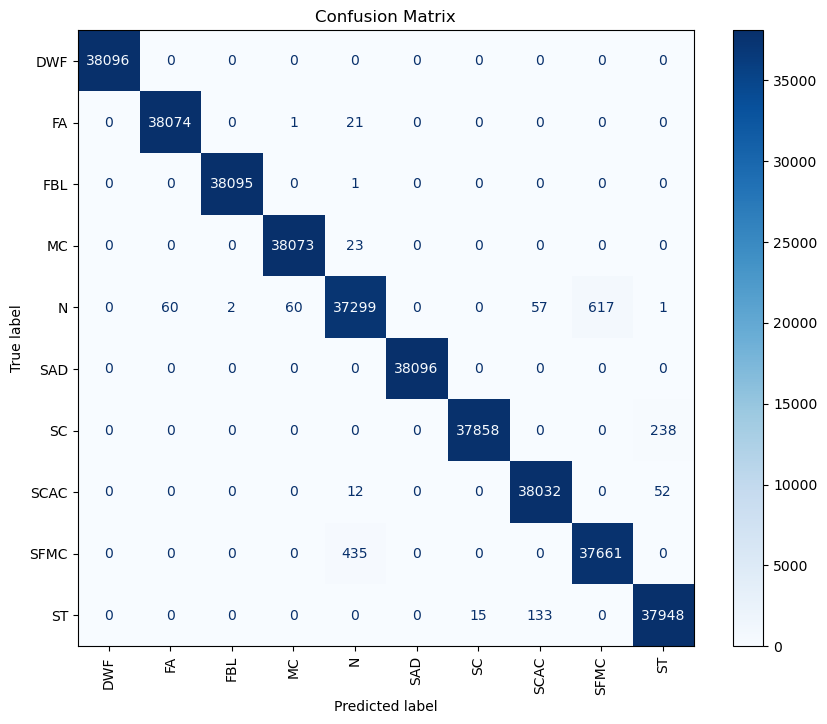

In [67]:
# Labeled confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=labels,
    cmap="Blues",
    xticks_rotation="vertical"
)
disp.figure_.set_size_inches(10, 8)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)